In [145]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Wavelength Offset & LSF Estimation with Solar Cross-Correlation

This notebook showcases a full workflow to:

1. Load twilight RSS data and stack exposures for higher S/N.
2. Cross-correlate fibre spectra with a high-resolution solar template to estimate **wavelength shift** and **instrumental LSF (Gaussian $\sigma$ in pixels)**, on a per-fibre basis.
3. Inspect and QA the per-window fits.
4. Build an LSF model on the instrument grid (`FibreLSFModel`), save it, and visualize it.
5. Save and apply the **wavelength offset** to other data.
6. (Optional) Degrade spectra to the worst resolution across fibres for uniform LSF.

We’ll focus on the solar-cross-correlation approach, which is very effective with **twilight exposures**. In other contexts, telluric emission/absorption or other references may be preferable (see the module docs).

## Why wavelength offsets exist

Small RSS wavelength offsets typically arise from: calibration imperfections, finite spectrograph precision, flexure, thermal drifts, and atmospheric or detector-related subtleties. These can vary by fibre and across the wavelength range, hence the need for per-fibre estimation and (optionally) per-window modeling.

## Three common anchoring strategies

- **Telluric emission lines** (excellent when bright and unblended; strongest beyond 5577 Å, less useful in the blue; can be contaminated by bright sources).
- **Telluric absorption bands** (good when sources dominate; mainly in the red; requires careful treatment of blends).
- **Cross-correlation with a reference spectrum** (e.g., using a solar template with twilight exposures; often very accurate, but depends on when those exposures are taken).  

This tutorial uses the third option.

> ### TL;DR workflow
> 1. Load/stack twilight RSS ➜ `combine_rss`  
> 2. Make solar correction ➜ `SolarCrossCorrOffset.from_fits()`  
> 3. Fit per-fibre shift & LSF ➜ `fit_solar_spectra(...)`  
> 4. Inspect fits ➜ `plot_fit_for_fibre(...)`  
> 5. Save & apply offset ➜ `WavelengthOffset.to_fits(...)` / `WavelengthCorrection.apply(...)`  
> 6. Build/Save LSF model ➜ `FibreLSFModel.from_sparse(...)` / `.to_fits(...)`  
> 7. (Optional) Degrade to worst LSF ➜ `FibreLSFModel.degrade_to_worst(...)`

## Data selection

We’ll use AAOmega KOALA twilight frames. The 580V grating (blue arm) covers ~3700–6000 Å; 385R (red arm) covers ~6000–9000 Å. Choose one:

- `580V` ➜ blue
- `385R` ➜ red

Make sure the paths used below match your local data layout (the example expects `../data/koala/<grating>/...`).

In [146]:
# Select the AAOMEGA grating (580V -> blue arm, 385R -> red arm)
aaomega_gratings = {'580V': 1, '385R': 2}
grating = '580V'  # <-- change to '385R' if you want the red arm

Now import the modules required for this tutorial.

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt

from pykoala.instruments.koala_ifu import koala_rss
from pykoala.rss import combine_rss
from pykoala.corrections.wavelength import SolarCrossCorrOffset, FibreLSFModel
from pykoala.plotting.utils import plot_fibres

# Reproducibility of plots
np.random.seed(42)

## Load & stack twilight exposures

Using consecutive twilight frames lets us assume a common offset; stacking increases S/N. Here we try a handful of files; missing files are skipped with a notice.

[pykoala] 2025/09/19 15:28|INFO> 
> Reading KOALA RSS file 27feb10009red.fits
[pykoala] 2025/09/19 15:28|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2025/09/19 15:28|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[pykoala] 2025/09/19 15:28|INFO> 
> Reading KOALA RSS file 27feb10010red.fits
[pykoala] 2025/09/19 15:28|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2025/09/19 15:28|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[pykoala] 2025/09/19 15:28|INFO> 
> Reading KOALA RSS file 27feb10011red.fits
[pykoala] 2025/09/19 15:28|INFO> No. of fibres in this RSS =1000
No. of good fibres = 986
No. of bad fibres = 14
[pykoala] 2025/09/19 15:28|INFO> Bad fibres = [109, 110, 235, 424, 574, 607, 675, 714, 721, 722, 723, 793, 950, 951]
[pykoala] 2025/09/19 15:28|INFO> 
> Reading KOALA RSS file 27feb10012red.fit

  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
  'Angstroms' -> 'Angstrom'. [astropy.wcs.wcs]
/home/pcorchoc/Develop/koala/src/pykoala/rss.py:50: RuntimeWarning: Mean of empty slice
  new_intensity = combine_function(all_intensities, axis=0
/home/pcorchoc/Develop/koala/src/pykoala/rss.py:52: RuntimeWarning: Mean of empty slice
  new_variance = combine_function(all_variances, axis=0


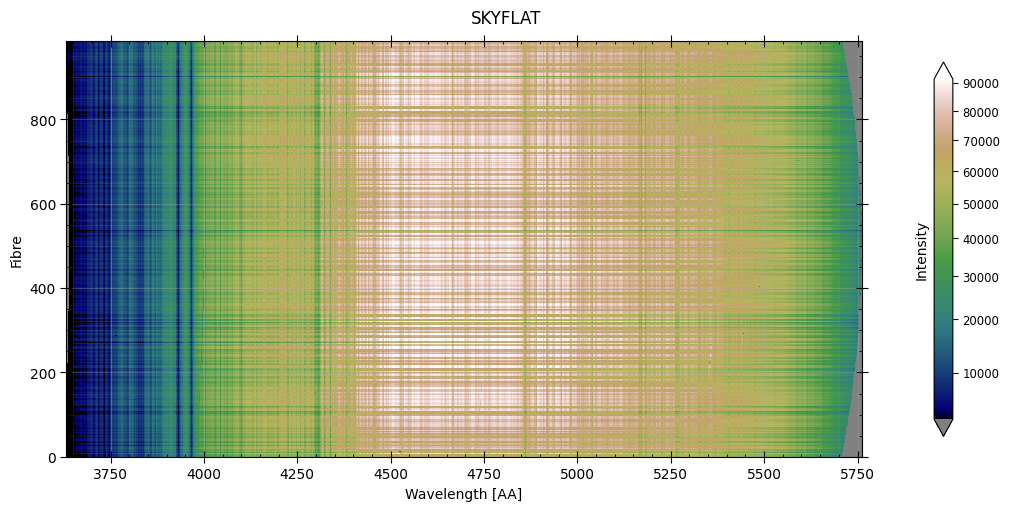

In [148]:
rss_list = []
candidates = [9, 10, 11, 12]
base = os.path.join("..", "data", "koala", grating)

for i in candidates:
    path = os.path.join(base, f"27feb{aaomega_gratings[grating]}00{i:02d}red.fits")
    if os.path.exists(path):
        rss_list.append(koala_rss(path))
    else:
        print(f"[warn] missing file: {path} — skipping")

if not rss_list:
    raise FileNotFoundError("No twilight files found — please adjust paths above.")

stacked_rss = combine_rss(rss_list, combine_method='nanmean')
stacked_rss.plot_rss_image()
plt.show()

# Initialise the solar cross-correction

We’ll use the built-in factory to load the solar template distributed with the package. This template is used as the reference for cross-correlation and for generating convolved/shifted model grids on the instrument’s wavelength grid.

In [149]:
help(SolarCrossCorrOffset)

Help on class SolarCrossCorrOffset in module pykoala.corrections.wavelength:

class SolarCrossCorrOffset(WavelengthCorrection)
 |  SolarCrossCorrOffset(sun_wavelength, sun_intensity, **kwargs)
 |  
 |  WavelengthCorrection based on solar spectra cross-correlation.
 |  
 |  Constructs a WavelengthOffset using a cross-correlation between a solar
 |  reference spectrum and a twilight exposure (dominated by solar features).
 |  
 |  Also implements Line Spread Function (LSF) estimation from the solar spectrum.
 |  
 |  Method resolution order:
 |      SolarCrossCorrOffset
 |      WavelengthCorrection
 |      pykoala.corrections.correction.CorrectionBase
 |      abc.ABC
 |      pykoala.VerboseMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, sun_wavelength, sun_intensity, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  compute_grid_of_models(self, pix_shift_array, pix_std_array, pix_array, sun_intensity, weights, i

In [150]:
solar_correction = SolarCrossCorrOffset.from_fits()
solar_correction.sun_wavelength, solar_correction.sun_intensity  # quick peek

(<Quantity [1.49958429e+03, 1.49973742e+03, 1.49989053e+03, ...,
            2.99850357e+06, 2.99880943e+06, 2.99911532e+06] Angstrom>,
 <Quantity [7.4901356e-05, 1.0486733e-04, 1.1720147e-04, ..., 2.9395453e-08,
            2.8444584e-08, 2.1750463e-08] erg / (Angstrom s cm2)>)

## Choosing windows & pre-processing parameters

Before fitting, we:

1. **Normalize** each fibre relative to the solar continuum via a median filter (width controlled by `response_window_size_aa`).
2. **Focus weighting** towards absorption features via `get_solar_features` (tune with `keep_features_frac`).
3. Optionally **mask tellurics** with `mask_tellurics=True`.

We’ll demonstrate two modes:

- **Single window** (`n_windows=1`) for a quick global offset & LSF per fibre (fast, robust first pass).
- **Multi-window** for a wavelength-dependent view of shift and LSF (more diagnostics, captures trends).

### A. Single-window (full band) fit

Good to start with: fewer failure modes and provides a reliable global per-fibre shift & LSF estimate.

In [151]:
single_results = solar_correction.fit_solar_spectra(
    stacked_rss,
    n_windows=1,                # full band
    window_overlap=0.25,        # ignored for single window
    response_window_size_aa=200,
    mask_tellurics=True,        # robust in presence of strong tellurics
    cont_order=1,               # forwarded to ancillary.fit_reference_spectra (if used there)
    make_lsf_model=True,        # also return an LSF model sampled on instrument grid
    smooth_sigma_pix=5          # optional smoothing of per-window sigma (here it’s single window)
)
list(single_results.keys())

[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:28|INFO> Fitting reference solar spectra to SpectraContainer.
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:28|INFO> Number of windows: 1, overlap fraction: 0.25
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:28|INFO> Renormalizing spectra by solar spectrum using window size 200 AA (193 pixels).
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:28|INFO> Masking telluric lines.
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:28|INFO> Fitting solar spectrum to each fibre and window.
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:28|INFO> Smoothing sigma_pix with median filter (5 pix)


['windows',
 'response',
 'wave',
 'normalized_rss',
 'normalized_rss_var',
 'fibre_0',
 'fibre_1',
 'fibre_2',
 'fibre_3',
 'fibre_4',
 'fibre_5',
 'fibre_6',
 'fibre_7',
 'fibre_8',
 'fibre_9',
 'fibre_10',
 'fibre_11',
 'fibre_12',
 'fibre_13',
 'fibre_14',
 'fibre_15',
 'fibre_16',
 'fibre_17',
 'fibre_18',
 'fibre_19',
 'fibre_20',
 'fibre_21',
 'fibre_22',
 'fibre_23',
 'fibre_24',
 'fibre_25',
 'fibre_26',
 'fibre_27',
 'fibre_28',
 'fibre_29',
 'fibre_30',
 'fibre_31',
 'fibre_32',
 'fibre_33',
 'fibre_34',
 'fibre_35',
 'fibre_36',
 'fibre_37',
 'fibre_38',
 'fibre_39',
 'fibre_40',
 'fibre_41',
 'fibre_42',
 'fibre_43',
 'fibre_44',
 'fibre_45',
 'fibre_46',
 'fibre_47',
 'fibre_48',
 'fibre_49',
 'fibre_50',
 'fibre_51',
 'fibre_52',
 'fibre_53',
 'fibre_54',
 'fibre_55',
 'fibre_56',
 'fibre_57',
 'fibre_58',
 'fibre_59',
 'fibre_60',
 'fibre_61',
 'fibre_62',
 'fibre_63',
 'fibre_64',
 'fibre_65',
 'fibre_66',
 'fibre_67',
 'fibre_68',
 'fibre_69',
 'fibre_70',
 'fibre_71'

**Quick look:** per-fibre global shift/sigma from the single window.

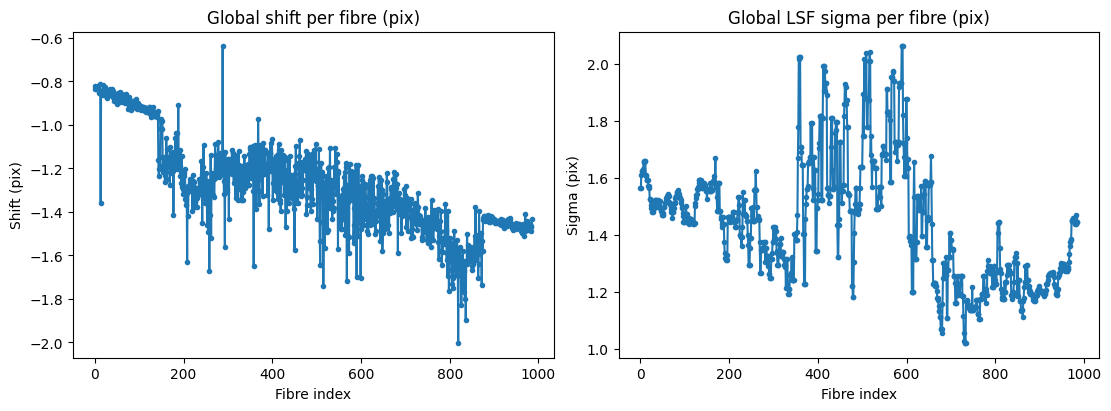

In [152]:
shift1 = single_results["shift_pix_matrix"][:, 0]
sigma1 = single_results["sigma_pix_matrix"][:, 0]

fig, ax = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)
ax[0].plot(shift1, '.-')
ax[0].set_title('Global shift per fibre (pix)')
ax[0].set_xlabel('Fibre index')
ax[0].set_ylabel('Shift (pix)')
ax[1].plot(sigma1, '.-')
ax[1].set_title('Global LSF sigma per fibre (pix)')
ax[1].set_xlabel('Fibre index')
ax[1].set_ylabel('Sigma (pix)')
plt.show()

> **Tip:** If you only need a stable per-fibre scalar offset to apply broadly, the single window pass is usually sufficient and fast. Use the multi-window mode to diagnose wavelength trends or build richer LSF models.

### B. Multi-window fit

Now fit the same RSS but split the band into multiple overlapping windows. This recovers **shift($\lambda$)** and **$\sigma(\lambda)$** trends and provides additional QC handles. The result can be turned into a `FibreLSFModel` directly (already demonstrated in the single-window call; it works the same here with more samples).

In [153]:
multi_results = solar_correction.fit_solar_spectra(
    stacked_rss,
    n_windows=5,
    window_overlap=0.3,
    response_window_size_aa=200,
    mask_tellurics=True,
    cont_order=1,
    make_lsf_model=True,
    smooth_sigma_pix=3
)
centres = multi_results["windows"]["centers"]
shift_mat = multi_results["shift_pix_matrix"]
sigma_mat = multi_results["sigma_pix_matrix"]
shift_mat.shape, sigma_mat.shape

[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:28|INFO> Fitting reference solar spectra to SpectraContainer.
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:28|INFO> Number of windows: 5, overlap fraction: 0.3
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:28|INFO> Renormalizing spectra by solar spectrum using window size 200 AA (193 pixels).
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:28|INFO> Masking telluric lines.
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:28|INFO> Fitting solar spectrum to each fibre and window.
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:28|INFO> Smoothing sigma_pix with median filter (3 pix)


((986, 5), (986, 5))

**Visualize** per-fibre, per-window shift and LSF. Below we plot all fibres (light points) and overlay the field median with error bars (std across fibres) to summarize trends with wavelength window center.

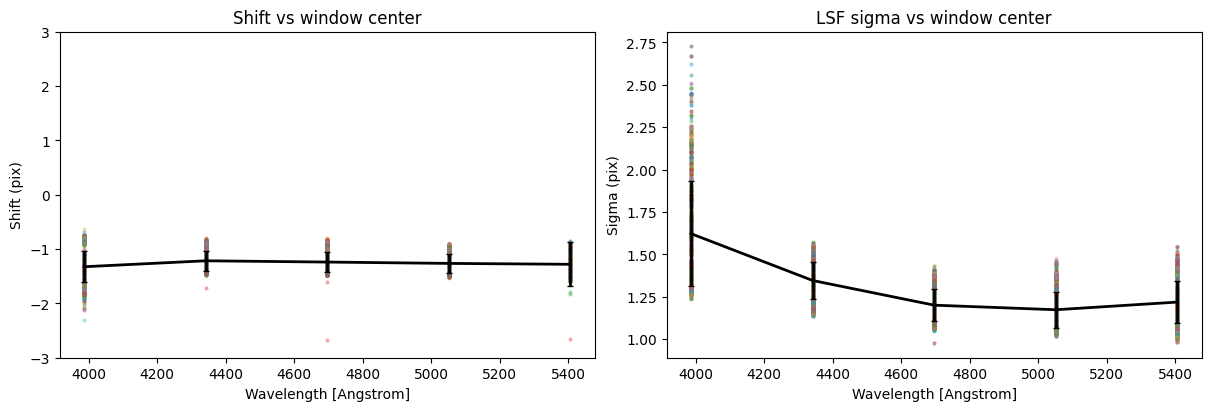

In [154]:
centres_val = np.array([c.to_value(stacked_rss.wavelength.unit) for c in centres])

fig, ax = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# Shift
for row in shift_mat:
    ax[0].plot(centres_val, row, 'o', ms=2, alpha=0.3)
ax[0].errorbar(centres_val, np.nanmedian(shift_mat, axis=0),
               yerr=np.nanstd(shift_mat, axis=0), color='k', lw=2, capsize=2)
ax[0].set_title('Shift vs window center')
ax[0].set_xlabel(f'Wavelength [{stacked_rss.wavelength.unit}]')
ax[0].set_ylabel('Shift (pix)')
ax[0].set_ylim(-3, 3)
# Sigma
for row in sigma_mat:
    ax[1].plot(centres_val, row, 'o', ms=2, alpha=0.3)
ax[1].errorbar(centres_val, np.nanmedian(sigma_mat, axis=0),
               yerr=np.nanstd(sigma_mat, axis=0), color='k', lw=2, capsize=2)
ax[1].set_title('LSF sigma vs window center')
ax[1].set_xlabel(f'Wavelength [{stacked_rss.wavelength.unit}]')
ax[1].set_ylabel('Sigma (pix)')

plt.show()

## Inspect per-fibre window fits (QC)

Use `plot_fit_for_fibre` to review data vs. model in each window, residuals, and a summary of shift/sigma across windows. Adjust `max_windows` for quick previews.

> If `n_windows=1`, this will still produce a single window panel + a summary figure; handy to confirm the global fit.


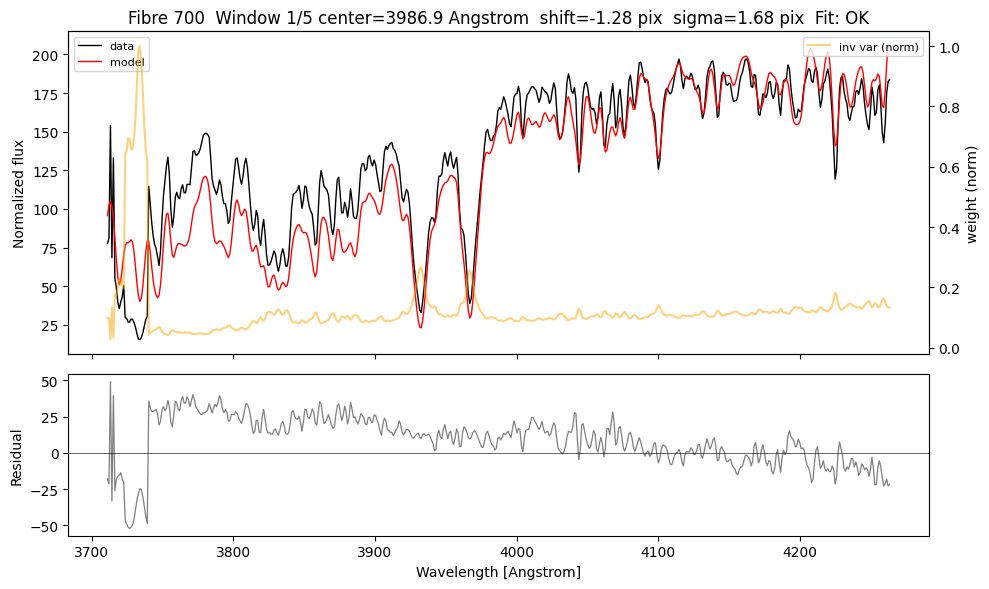

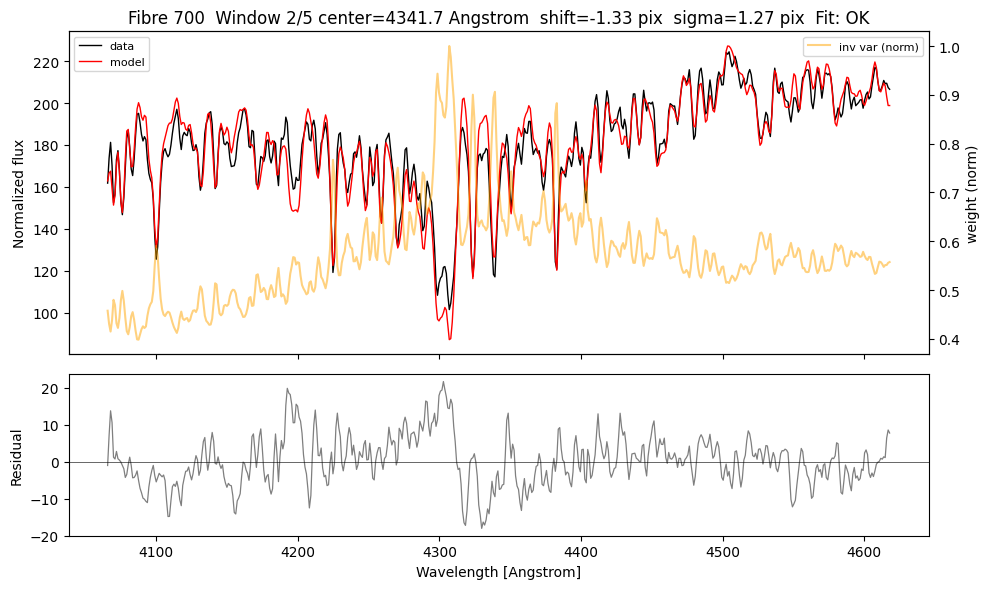

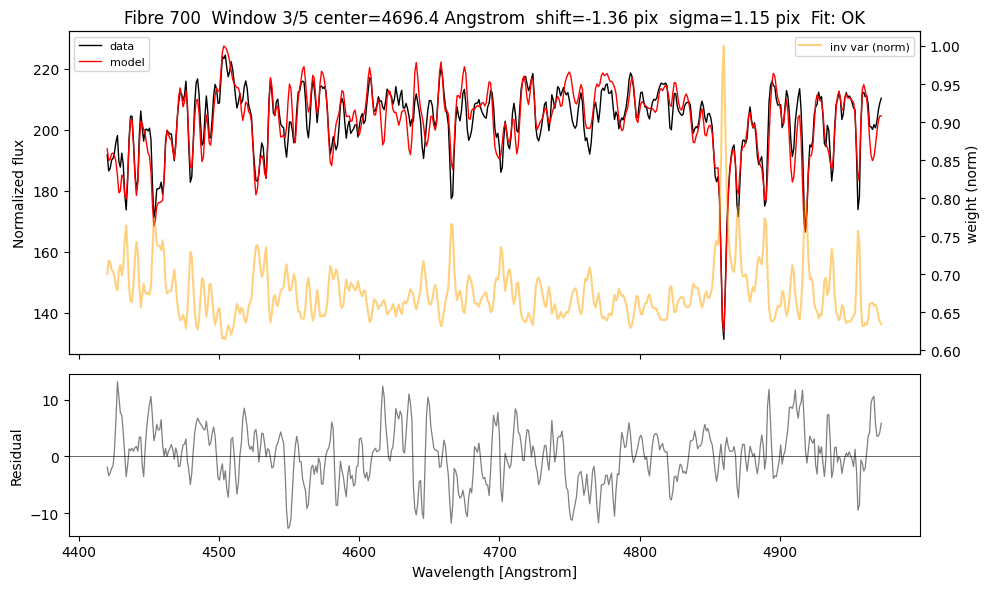

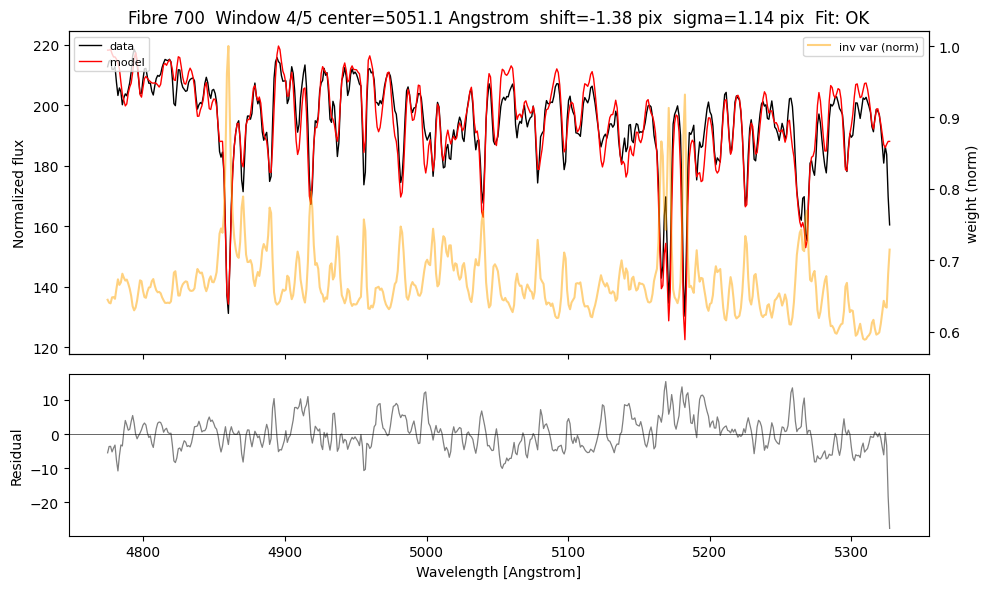

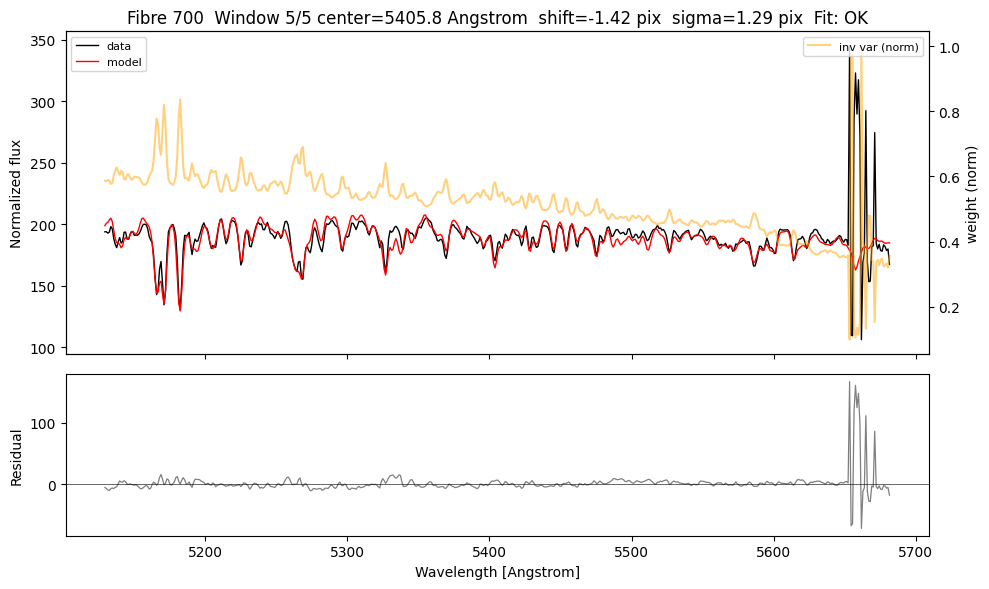

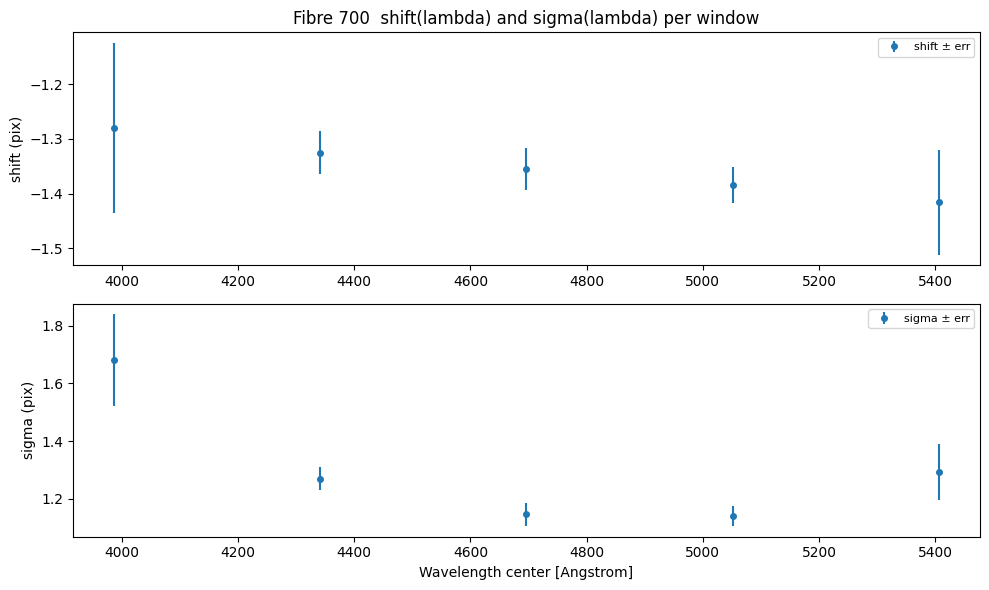

In [155]:
fibre_to_check = min(700, stacked_rss.intensity.shape[0]-1)  # guard in case dataset has fewer fibres
figs = solar_correction.plot_fit_for_fibre(
    fibre_to_check,
    fit_results=multi_results,
    max_windows=None,          # or set a small int (e.g., 2) for a quick check
    show_models=True,
    show_residuals=True,
    show_weights=True,
    figsize=(10, 6)
)
for fig in figs:
    plt.figure(fig)
    plt.show()

## Mapping results on the sky (fibre footprint)

Plot the median **shift** and **sigma** per fibre across windows on the KOALA footprint using `plot_fibres` (RA/DEC map). This highlights field-dependent systematics or flexure patterns.

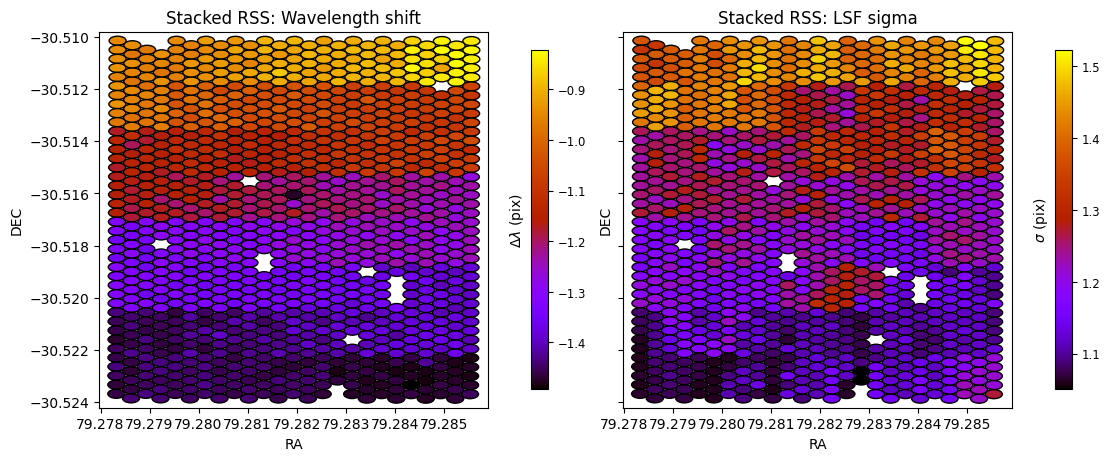

In [156]:
median_shift = np.nanmedian(multi_results["shift_pix_matrix"], axis=1)
median_sigma = np.nanmedian(multi_results["sigma_pix_matrix"], axis=1)

fig, axs = plt.subplots(ncols=2, figsize=(11, 4.5), constrained_layout=True, sharex=True, sharey=True)

ax = axs[0]
ax.set_title("Stacked RSS: Wavelength shift")
ax.set_xlabel("RA")
ax.set_ylabel("DEC")
_ = plot_fibres(fig, ax, rss=stacked_rss, data=median_shift, norm=plt.Normalize(),
                 cmap='gnuplot', cblabel=r'$\Delta\lambda$ (pix)')

ax = axs[1]
ax.set_title("Stacked RSS: LSF sigma")
ax.set_xlabel("RA")
ax.set_ylabel("DEC")
_ = plot_fibres(fig, ax, rss=stacked_rss, data=median_sigma, norm=plt.Normalize(),
                 cmap='gnuplot', cblabel=r'$\sigma$ (pix)')

plt.show()

## Save & apply the wavelength offset

After fitting, you may save a per-fibre **scalar** offset (e.g. median across windows) or a **per-window** model. The convenience method in this demo stores a per-fibre scalar in `solar_correction.offset`. Save it and apply to RSS data as needed. You can rerun the fit afterward to verify that residual shifts are ~0.

> Tip: If you plan to re-use this offset later, store it under your project’s products path (created if missing below).

[pykoala] 2025/09/19 15:29|INFO> Wavelength offset saved at ../products/koala/580V/wavelength_offset.fits
Saved wavelength offset to: ../products/koala/580V/wavelength_offset.fits
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:29|INFO> Applying correction to input RSS
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:29|INFO> Fitting reference solar spectra to SpectraContainer.
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:29|INFO> Number of windows: 5, overlap fraction: 0.25
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:29|INFO> Renormalizing spectra by solar spectrum using window size 200 AA (193 pixels).
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:29|INFO> Masking telluric lines.
[pykoala.correction.SolarCrossCorrelationOffset] 2025/09/19 15:29|INFO> Fitting solar spectrum to each fibre and window.
Median |residual shift| (pix): 0.032807513653980075


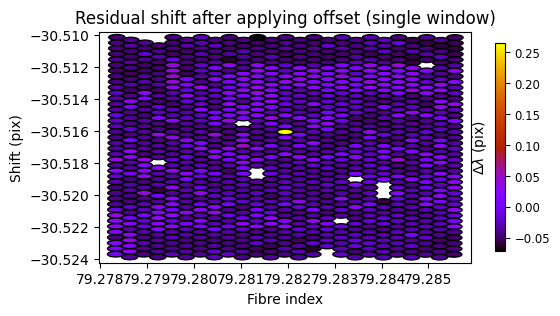

In [ ]:
products_dir = os.path.join("..", "products", "koala", grating)
os.makedirs(products_dir, exist_ok=True)
offset_path = os.path.join(products_dir, "wavelength_offset.fits")

solar_correction.offset.to_fits(offset_path)
print(f"Saved wavelength offset to: {offset_path}")

# Apply to stacked RSS (creates a corrected copy)
stacked_rss_corr = solar_correction.apply(stacked_rss)

# Optional: verify residuals are near-zero (quick single-window check)
post = solar_correction.fit_solar_spectra(stacked_rss_corr, n_windows=5,
                                          cont_order=1, mask_tellurics=True)

residual_shift = np.nanmedian(post["shift_pix_matrix"], axis=1)
print("Median |residual shift| (pix):", float(np.nanmedian(np.abs(residual_shift))))
fig, ax = plt.subplots(figsize=(6,3))
_ = plot_fibres(fig, ax, rss=stacked_rss_corr, data=residual_shift, norm=plt.Normalize(),
                cmap='gnuplot', cblabel=r'$\Delta\lambda$ (pix)')

ax.set_title('Residual shift after applying offset (single window)')
ax.set_xlabel('Fibre index')
ax.set_ylabel('Shift (pix)')
plt.show()

## LSF modelling: build, visualize, and save

`fit_solar_spectra(..., make_lsf_model=True)` returns a ready-sampled `FibreLSFModel` on the instrument grid. You can also “rebuild” a model using sparse window centers and measurements with `FibreLSFModel.from_sparse` and later refine or re-fit models (`fit_models`). Below we visualize and save the model to FITS for future use.

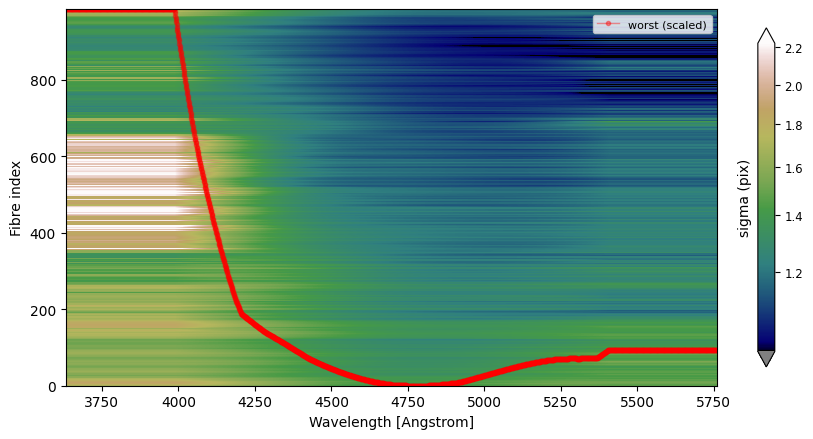

[pykoala] 2025/09/19 15:29|INFO> LSF saved to ../products/koala/580V/lsf_model.fits
Saved LSF model to: ../products/koala/580V/lsf_model.fits


In [158]:
lsf_model = multi_results.get("lsf_model", None)
if lsf_model is None:
    # Fallback: build from sparse (centres & sigma per fibre)
    lsf_model = FibreLSFModel.from_sparse(
        instrument_wavelength=stacked_rss.wavelength,
        centres=multi_results["windows"]["centers"],
        sigma_values=multi_results["sigma_pix_matrix"],
        kind="spline",
        degree=3
    )

fig = lsf_model.plot_sigma_image()
plt.figure(fig)
plt.show()

lsf_path = os.path.join(products_dir, "lsf_model.fits")
lsf_model.to_fits(lsf_path)
print(f"Saved LSF model to: {lsf_path}")

## (Optional) Degrade spectra to the worst LSF across fibres

For homogeneous resolution across the field, convolve each fibre with a wavelength-dependent Gaussian so that every fibre matches the **worst** sigma at each wavelength. This is helpful before co-adding spectra spatially or comparing line widths across fibres.

> This operation preserves flux approximately; variance is propagated with a simple filter-variance approximation (see docstring for details).

Degraded spectra to worst LSF across fibres.


(4152.082749419497, 4256.050935045597)

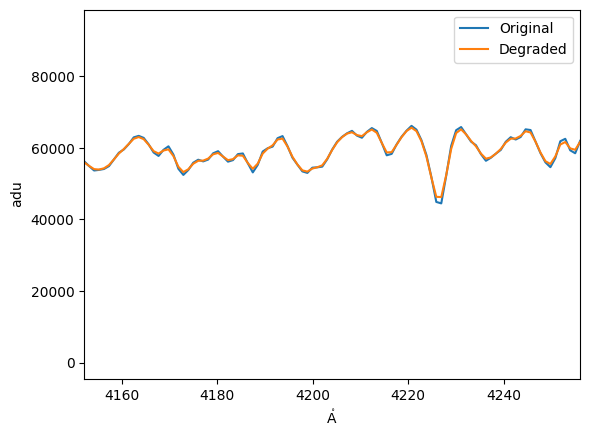

In [159]:
rss_worst = lsf_model.degrade_to_worst(stacked_rss_corr, use_models=True, n_knots=16)
print("Degraded spectra to worst LSF across fibres.")

fibre = 500

plt.figure()
plt.plot(stacked_rss_corr.wavelength, stacked_rss_corr.intensity[fibre],
         label="Original")
plt.plot(rss_worst.wavelength, rss_worst.intensity[fibre],
         label="Degraded")
plt.legend()
plt.xlim(rss_worst.wavelength[500], rss_worst.wavelength[600])

# Practical guidance & troubleshooting

### Parameter tuning
- **`n_windows`**: start with 1 for stability; increase (e.g., 5–12) to capture wavelength trends. Too many windows with little S/N can lead to noisy estimates.
- **`window_overlap`**: small overlaps (0.2–0.4) help smooth transitions and increase robustness near window edges.
- **`response_window_size_aa`**: choose a scale larger than absorption features but smaller than the instrument bandpass curvature (e.g., 150–300 Å). If too small, residual continuum shapes can bias fits; too large can over-smooth real response variations.
- **`keep_features_frac`**: typical values 0.10–0.20. Smaller ➜ focus on the very strongest lines; larger ➜ include more context (may dilute the signal if too large).
- **`mask_tellurics`**: set `True` if strong telluric bands are present; the fitter down-weights those pixels.

### Common pitfalls
- **Missing data files**: check paths and filenames; the loader code prints any missing candidates.
- **Bad/NaN variance**: the fitter uses 1/variance in weights; non-finite or zero variance is handled but may reduce robustness. Ensure variance arrays are realistic.
- **Edge windows too small**: if fewer than ~5 valid pixels fall into a window (after masks), that window is skipped.
- **Very large shifts/sigmas**: the defaults are tuned for typical KOALA configurations. If your instrument is very different, adjust the grids in your underlying fit method (`ancillary.fit_reference_spectra`).

### Reproducibility & performance
- For quick, reliable offsets: **single window** is usually best.
- For QA and wavelength trends: use **multi-window**. Consider smoothing (`smooth_sigma_pix`) to stabilize $\sigma(\lambda)$ if needed.
- For very large datasets, pre-stacking multiple similar exposures (as we did) improves S/N and reduces runtime outliers.

### Artifacts to save
- **Wavelength offset** FITS: `WavelengthOffset.to_fits(...)` ➜ later load with `WavelengthOffset.from_fits(...)` or via `WavelengthCorrection.from_fits(...)`.
- **LSF model** FITS: `FibreLSFModel.to_fits(...)` & `.from_fits(...)`.
- QC figures for selected fibres: `plot_fit_for_fibre(...)`.